In [1]:
import os, re
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from combat.pycombat import pycombat

In [2]:
get_tables_path = lambda fname: os.path.normpath('../local_data/processed_data/'+ fname)

In [3]:
file_cptac_transcriptomics = get_tables_path('CPTAC_transcriptomics_linkedomics.parquet')
file_xena_transcriptomics = get_tables_path('TCGA_xena_transcriptomics_VAE_input.parquet')
file_tcga_survival_analysis = get_tables_path('Survival_SupplementalTable_S1_20171025_xena_sp')
file_cptac_sample_info = get_tables_path('CPTAC_sample_info.parquet')

In [4]:
xena_transcriptomics = pd.read_parquet(file_xena_transcriptomics)
print(xena_transcriptomics.shape)
xena_transcriptomics[:2]

(14722, 11060)


,TCGA-02-0047-01,TCGA-02-0055-01,TCGA-02-2483-01,TCGA-02-2485-01,TCGA-02-2486-01,TCGA-04-1348-01,TCGA-04-1357-01,TCGA-04-1362-01,TCGA-04-1364-01,TCGA-04-1365-01,...,TCGA-ZR-A9CJ-01,TCGA-ZS-A9CD-01,TCGA-ZS-A9CE-01,TCGA-ZS-A9CF-01,TCGA-ZS-A9CF-02,TCGA-ZS-A9CG-01,TCGA-ZT-A8OM-01,TCGA-ZU-A8S4-01,TCGA-ZU-A8S4-11,TCGA-ZX-AA5X-01
sample,,,,,,,,,,,,,,,,,,,,,
CEACAM6,0.69,1.70,0.0,0.0,0.0,2.59,8.68,9.15,4.64,5.22,...,8.10,0.81,0.63,1.62,3.18,0.0,6.99,11.61,3.10,13.51
TMPRSS4,0.00,0.64,0.0,0.0,0.0,9.42,11.88,12.49,9.02,11.17,...,11.45,0.81,3.29,2.15,1.16,0.0,0.99,6.74,2.68,11.44


In [5]:
tcga_sample_info = pd.read_csv(file_tcga_survival_analysis, sep='\t', usecols=['sample', 'cancer type abbreviation'])
tcga_sample_info = tcga_sample_info.rename(columns={'cancer type abbreviation': 'Study'}).set_index('sample')
tcga_sample_info['Study'] = tcga_sample_info['Study'].apply(lambda x: 'TCGA-'+x)
tcga_sample_info['Project'] = 'TCGA'
print("Dimensions: ", tcga_sample_info.shape)
tcga_sample_info[:2]

Dimensions:  (12591, 2)


,Study,Project
sample,,
TCGA-OR-A5J1-01,TCGA-ACC,TCGA
TCGA-OR-A5J2-01,TCGA-ACC,TCGA


In [6]:
xena_transcriptomics_study = xena_transcriptomics.T.merge(tcga_sample_info[['Study', 'Project']], 
                                                          left_index=True, right_index=True, how='inner')
xena_transcriptomics_study[:2]

,CEACAM6,TMPRSS4,SERPINB5,KRT5,SLC34A2,KLK11,AGR2,PIGR,CEACAM5,CXCL17,...,GP2,GPR142,KNG1,CXorf49B,IFIT1B,HTR4,CRP,WFDC5,Study,Project
TCGA-02-0047-01,0.69,0.00,0.00,0.69,8.19,0.0,0.0,2.84,0.0,0.69,...,0.0,1.79,1.16,0.69,0.69,2.03,0.00,0.0,TCGA-GBM,TCGA
TCGA-02-0055-01,1.70,0.64,0.64,3.68,0.64,0.0,0.0,1.08,0.0,0.00,...,0.0,0.00,0.00,0.00,0.00,1.42,0.64,0.0,TCGA-GBM,TCGA


In [7]:
cptac_transcriptomics = pd.read_parquet(file_cptac_transcriptomics)
print(cptac_transcriptomics.shape)
cptac_transcriptomics[:2]

(18819, 1901)


,01OV007,01OV017,01OV018,01OV023,01OV026,01OV030,01OV039,01OV041,01OV047,02OV005,...,X20BR002,X20BR005,X20BR006,X20BR007,X20BR008,X21BR001,X21BR002,X21BR010,X22BR005,X22BR006
A1BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.208,NaN,NaN,NaN,NaN,0.0983,NaN,-1.8883,-3.8105,-2.2787
A1CF,0.0,0.0,0.0,0.004795,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
cptac_sample_info = pd.read_parquet(file_cptac_sample_info)
cptac_sample_info['Study'] = cptac_sample_info['Study'].apply(lambda x: 'CPTAC-'+x)
cptac_sample_info['Project'] = 'CPTAC'
cptac_sample_info[:2]

,Gender,Age,Study,Project
C3L-00004,male,72.0,CPTAC-ccRCC,CPTAC
C3L-00010,male,30.0,CPTAC-ccRCC,CPTAC


In [9]:
cptac_sample_info['Study'].value_counts()

Study
CPTAC-BrCa2016    825
CPTAC-OvCa2016    174
CPTAC-Pdac        145
CPTAC-BrCa2020    122
CPTAC-LSCC        113
CPTAC-HNSCC       111
CPTAC-OvCa2020    111
CPTAC-ccRCC       110
CPTAC-LUAD        110
CPTAC-GBM         105
CPTAC-UCEC         95
Name: count, dtype: int64

In [10]:
cptac_transcriptomics_study = cptac_transcriptomics.T.merge(cptac_sample_info[['Study', 'Project']],
                                                             left_index=True, right_index=True, how='inner')
cptac_transcriptomics_study[:2]

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,Study,Project
01OV007,NaN,0.0,6.413164,0.044405,0.0,2.556665,0.0,4.260906,3.40598,NaN,...,0.652968,0.767192,2.326376,0.153136,2.354494,4.381353,1.253874,4.290388,CPTAC-OvCa2020,CPTAC
01OV017,NaN,0.0,5.466066,0.175751,0.0,1.719924,0.0,4.141343,3.27598,NaN,...,1.224744,1.374589,3.435347,0.100759,3.005854,3.801635,1.468635,4.950352,CPTAC-OvCa2020,CPTAC


In [11]:
def remove_genes_with_zero_variance(data):
    genes_with_zero_var = []
    for study in data['Study'].value_counts().index:
        var = data[data['Study'] == study].drop(columns=['Study']).var()
        genes_with_zero_var.append(var[var == 0].index)
        
    return(data.drop(columns = list(set([item for items in genes_with_zero_var for item in items]))))

def apply_combat_studywise(tcga_study, cptac_study, par_prior=True):
    tcga_study_transcriptomics = xena_transcriptomics_study[xena_transcriptomics_study['Study'].str.contains(tcga_study)]
    cptac_study_transcriptomics = cptac_transcriptomics_study[cptac_transcriptomics_study['Study'].str.contains(cptac_study)]
    
    common_proteins = np.intersect1d(tcga_study_transcriptomics.columns, cptac_study_transcriptomics.columns)
    print("Common proteins between TCGA and CPTAC: ", len(common_proteins))
    tcga_study_transcriptomics = tcga_study_transcriptomics.reindex(common_proteins, axis=1)
    cptac_study_transcriptomics = cptac_study_transcriptomics.reindex(common_proteins, axis=1)
    study_samples = pd.concat([tcga_study_transcriptomics, cptac_study_transcriptomics]).drop(columns='Project')
    print("Combined TCGA and CPTAC dimensions: ", study_samples.shape)
    study_samples = study_samples.dropna(thresh=0.6*(study_samples.shape[0]), axis=1).fillna(0).sort_values('Study', 
                                                                                                            ascending=False)
    print("Combined TCGA and CPTAC dimensions after dropping genes with 40% null: ", study_samples.shape)
    study_samples = remove_genes_with_zero_variance(study_samples)
    print("Combined TCGA and CPTAC dimensions after dropping genes with 0 variance: ", study_samples.shape)
    # Reverse sorting the studies to ensure TCGA study is the reference batch
    batch_sample_count = study_samples['Study'].value_counts().sort_index(ascending=False)
    
    batch = []
    for j in range(len(batch_sample_count)):
        batch.extend([j for _ in range(batch_sample_count[j])])
    combat_input = study_samples.drop(columns=['Study']).T
    combat_input = combat_input.loc[~(combat_input==0).all(axis=1)]
    transcriptomics_batch_corrected = pycombat(combat_input, batch, ref_batch=0, par_prior=par_prior)
    return(transcriptomics_batch_corrected)

In [12]:
cptac_normalized_datasets = pd.concat([apply_combat_studywise('BRCA', 'BrCa'), 
                                       apply_combat_studywise('UCEC', 'UCEC'), 
                                       apply_combat_studywise('LUAD', 'LUAD'),
                                       apply_combat_studywise('LUSC', 'LSCC'), 
                                       apply_combat_studywise('PAAD', 'Pdac'), 
                                       apply_combat_studywise('HNSC', 'HNSC'),
                                       apply_combat_studywise('OV', 'OvCa'),
                                       apply_combat_studywise('GBM', 'GBM'),
                                       apply_combat_studywise('KIRC', 'ccRCC')], axis=1).T
cptac_normalized_datasets[:2]

Common proteins between TCGA and CPTAC:  14724
Combined TCGA and CPTAC dimensions:  (2158, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 40% null:  (2158, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 0 variance:  (2158, 14642)
Using batch 0 as a reference batch.
Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\combat\pycombat.py:158: RuntimeWarning: divide by zero encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


Adjusting the Data
Common proteins between TCGA and CPTAC:  14724
Combined TCGA and CPTAC dimensions:  (650, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 40% null:  (650, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 0 variance:  (650, 14720)
Using batch 0 as a reference batch.
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\combat\pycombat.py:158: RuntimeWarning: divide by zero encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


Adjusting the Data
Common proteins between TCGA and CPTAC:  14724
Combined TCGA and CPTAC dimensions:  (686, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 40% null:  (686, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 0 variance:  (686, 14632)
Using batch 0 as a reference batch.
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\combat\pycombat.py:158: RuntimeWarning: divide by zero encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


Adjusting the Data
Common proteins between TCGA and CPTAC:  14724
Combined TCGA and CPTAC dimensions:  (660, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 40% null:  (660, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 0 variance:  (660, 14518)
Using batch 0 as a reference batch.
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\combat\pycombat.py:158: RuntimeWarning: divide by zero encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


Adjusting the Data
Common proteins between TCGA and CPTAC:  14724
Combined TCGA and CPTAC dimensions:  (323, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 40% null:  (323, 14720)
Combined TCGA and CPTAC dimensions after dropping genes with 0 variance:  (323, 14720)
Using batch 0 as a reference batch.
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\combat\pycombat.py:158: RuntimeWarning: divide by zero encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


Adjusting the Data
Common proteins between TCGA and CPTAC:  14724
Combined TCGA and CPTAC dimensions:  (675, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 40% null:  (675, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 0 variance:  (675, 14718)
Using batch 0 as a reference batch.
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\combat\pycombat.py:158: RuntimeWarning: divide by zero encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


Adjusting the Data
Common proteins between TCGA and CPTAC:  14724
Combined TCGA and CPTAC dimensions:  (495, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 40% null:  (495, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 0 variance:  (495, 12757)
Using batch 0 as a reference batch.
Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\combat\pycombat.py:158: RuntimeWarning: divide by zero encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


Adjusting the Data
Common proteins between TCGA and CPTAC:  14724
Combined TCGA and CPTAC dimensions:  (265, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 40% null:  (265, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 0 variance:  (265, 14663)
Using batch 0 as a reference batch.
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\combat\pycombat.py:158: RuntimeWarning: divide by zero encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


Common proteins between TCGA and CPTAC:  14724
Combined TCGA and CPTAC dimensions:  (716, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 40% null:  (716, 14723)
Combined TCGA and CPTAC dimensions after dropping genes with 0 variance:  (716, 14682)
Using batch 0 as a reference batch.
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\combat\pycombat.py:158: RuntimeWarning: divide by zero encountered in divide
  change = max(np.amax(np.absolute(g_new-np.asarray(g_old))/np.asarray(g_old)), np.amax(


Adjusting the Data


,A1BG,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,AAGAB,...,SPSB2,TBC1D3G,THEM5,TLCD1,TMEM217,WDR38,WDR83,ZACN,ZNF727,C4orf50
TCGA-3C-AAAU-01,7.63,12.50,1.25,6.11,3.27,9.35,10.09,0.00,2.70,10.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-D8-A13Z-01,4.49,13.45,11.21,7.83,1.53,8.98,10.03,3.05,8.84,10.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Drop all TCGA transcriptomics samples as we will combine it with all the other studies
cptac_normalized_datasets = cptac_normalized_datasets.drop(index=[index for index in cptac_normalized_datasets.index if (len(index) == 15) & (index.startswith('TCGA-'))])
print(cptac_normalized_datasets.shape)
cptac_normalized_datasets[:2]

(1901, 14721)


,A1BG,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,AAGAB,...,SPSB2,TBC1D3G,THEM5,TLCD1,TMEM217,WDR38,WDR83,ZACN,ZNF727,C4orf50
X05BR044,-0.6153,-0.5602,5.4596,-1.4839,0.0,-0.0419,4.3978,1.2984,5.6996,-0.0230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X06BR006,-2.2182,2.7292,4.1479,6.6384,0.0,-0.1489,1.0943,1.3643,0.7866,-1.4821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# cptac_normalized_datasets = cptac_normalized_datasets.dropna(axis=1, thresh=0.6*(len(cptac_normalized_datasets))).fillna(0)

In [15]:
cptac_normalized_subset = cptac_normalized_datasets.dropna(thresh=0.6*(len(cptac_normalized_datasets)), axis=1)
print(cptac_normalized_subset.shape)
cptac_normalized_subset[:2] 

(1901, 14640)


,A1BG,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
X05BR044,-0.6153,-0.5602,5.4596,-1.4839,0.0,-0.0419,4.3978,1.2984,5.6996,-0.0230,...,8.618797,9.045641,5.702161,8.969871,10.078963,6.158343,9.731291,11.746162,10.243323,9.830872
X06BR006,-2.2182,2.7292,4.1479,6.6384,0.0,-0.1489,1.0943,1.3643,0.7866,-1.4821,...,8.615722,8.951887,5.917737,8.896031,10.041867,6.556319,9.805989,11.801935,10.200021,9.784271


In [16]:
transcriptomics_mad = pd.DataFrame(stats.median_abs_deviation(cptac_normalized_subset, axis=0), 
                                   index = cptac_normalized_subset.columns, 
                                   columns= ['MAD']).dropna().sort_values(by='MAD', ascending=False)
variable_genes = transcriptomics_mad[transcriptomics_mad['MAD'] > 0].index
cptac_normalized_subset = cptac_normalized_subset.reindex(variable_genes, axis=1)
print(cptac_normalized_subset.shape)
cptac_normalized_subset[:2]

(1901, 12581)


,ABCC9,AGR3,TFF1,ABCC11,ABCC8,LMX1B,ABCA12,TMPRSS4,CEACAM5,PRAME,...,UBE2D3,CNOT2,PPWD1,DDX24,IWS1,PDCL,CWC22,ZNF143,ZNF317,APOH
X05BR044,-0.1642,-6.9695,7.315253,5.6987,-0.1320,9.006253,4.4880,3.713072,7.641153,4.239446,...,12.275687,10.487446,8.585484,11.455538,10.169584,8.862867,9.241903,8.464633,9.525920,0.0
X06BR006,3.5734,-2.2886,5.863440,3.0420,-0.3577,7.406507,3.2958,5.309702,7.748331,3.532511,...,12.284750,10.495988,8.608105,11.460543,10.111001,8.915071,9.168362,8.481458,9.539754,0.0


In [17]:
cptac_transcriptomics_processed = cptac_normalized_subset.fillna(0).T
rnaseq_scaled_zeroone_df = MinMaxScaler().fit_transform(cptac_transcriptomics_processed)
cptac_transcriptomics_processed = pd.DataFrame(rnaseq_scaled_zeroone_df,
                                        columns=cptac_transcriptomics_processed.columns,
                                        index=cptac_transcriptomics_processed.index)
cptac_transcriptomics_processed[:2]

,X05BR044,X06BR006,X06BR005,X06BR003,X05BR045,X05BR016,X05BR043,X05BR042,X05BR038,X05BR029,...,C3L-00908,C3L-00907,C3L-00902,C3L-00817,C3L-00814,C3L-00813,C3L-00812,C3L-00800,C3L-00799,C3N-01808
ABCC9,0.335605,0.437866,0.289582,0.369700,0.274862,0.248999,0.300973,0.273792,0.365365,0.244641,...,0.106512,0.092456,0.147244,0.165088,0.112657,0.140601,0.172404,0.138284,0.102863,0.189004
AGR3,0.060490,0.196469,0.279060,0.450851,0.028310,0.426830,0.044012,0.000000,0.456943,0.000000,...,0.002412,0.000000,0.010735,0.000000,0.000000,0.005646,0.000000,0.007103,0.000000,0.000000


In [18]:
cptac_transcriptomics_processed.to_parquet(get_tables_path('CPTAC_Transcriptomics_processed.parquet'))

### Input for the VAE

In [19]:
cptac_normalized_study = cptac_normalized_subset.merge(cptac_sample_info[['Study', 'Project']], 
                                                       right_index=True, left_index=True)
cptac_normalized_study[:2]

,ABCC9,AGR3,TFF1,ABCC11,ABCC8,LMX1B,ABCA12,TMPRSS4,CEACAM5,PRAME,...,PPWD1,DDX24,IWS1,PDCL,CWC22,ZNF143,ZNF317,APOH,Study,Project
X05BR044,-0.1642,-6.9695,7.315253,5.6987,-0.1320,9.006253,4.4880,3.713072,7.641153,4.239446,...,8.585484,11.455538,10.169584,8.862867,9.241903,8.464633,9.525920,0.0,CPTAC-BrCa2020,CPTAC
X06BR006,3.5734,-2.2886,5.863440,3.0420,-0.3577,7.406507,3.2958,5.309702,7.748331,3.532511,...,8.608105,11.460543,10.111001,8.915071,9.168362,8.481458,9.539754,0.0,CPTAC-BrCa2020,CPTAC


In [20]:
assert 'Study' in cptac_normalized_study.columns, "Study is not in CPTAC columns"
assert 'Project' in cptac_normalized_study.columns, "Project is not in CPTAC columns"
assert 'Study' in xena_transcriptomics_study.columns, "Study is not in CPTAC columns"
assert 'Project' in xena_transcriptomics_study.columns, "Project is not in CPTAC columns"

In [21]:
common_columns = np.intersect1d(cptac_normalized_study.columns, xena_transcriptomics_study.columns)
xena_transcriptomics_study = xena_transcriptomics_study.reindex(common_columns, axis=1)
print(xena_transcriptomics_study.shape)
xena_transcriptomics_study[:2]

(11014, 12583)


,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-02-0047-01,15.05,5.40,5.22,1.16,8.87,8.92,7.87,10.01,10.45,10.83,...,8.03,8.66,6.05,8.48,10.12,0.69,10.24,11.92,10.45,9.24
TCGA-02-0055-01,15.39,1.42,8.93,0.64,9.22,8.31,6.66,10.41,9.97,10.89,...,8.87,7.95,5.45,8.14,9.25,2.60,9.85,13.49,9.25,9.49


In [22]:
combined_datasets = pd.concat([cptac_normalized_study, xena_transcriptomics_study])
combined_datasets = combined_datasets.fillna(0)
print(combined_datasets.shape)
combined_datasets[:2]

(12915, 12583)


,ABCC9,AGR3,TFF1,ABCC11,ABCC8,LMX1B,ABCA12,TMPRSS4,CEACAM5,PRAME,...,PPWD1,DDX24,IWS1,PDCL,CWC22,ZNF143,ZNF317,APOH,Study,Project
X05BR044,-0.1642,-6.9695,7.315253,5.6987,-0.1320,9.006253,4.4880,3.713072,7.641153,4.239446,...,8.585484,11.455538,10.169584,8.862867,9.241903,8.464633,9.525920,0.0,CPTAC-BrCa2020,CPTAC
X06BR006,3.5734,-2.2886,5.863440,3.0420,-0.3577,7.406507,3.2958,5.309702,7.748331,3.532511,...,8.608105,11.460543,10.111001,8.915071,9.168362,8.481458,9.539754,0.0,CPTAC-BrCa2020,CPTAC


In [23]:
combined_datasets['Project'].value_counts()

Project
TCGA     11014
CPTAC     1901
Name: count, dtype: int64

In [24]:
combined_datasets['Study'].value_counts()

Study
TCGA-BRCA         1215
CPTAC-BrCa2016     821
TCGA-KIRC          606
TCGA-LUAD          576
TCGA-THCA          572
TCGA-HNSC          566
TCGA-UCEC          555
TCGA-LUSC          552
TCGA-PRAD          550
TCGA-LGG           529
TCGA-COAD          492
TCGA-SKCM          473
TCGA-STAD          450
TCGA-BLCA          427
TCGA-LIHC          423
TCGA-KIRP          323
TCGA-CESC          309
TCGA-OV            308
TCGA-SARC          265
TCGA-ESCA          196
TCGA-PCPG          187
TCGA-PAAD          183
TCGA-LAML          173
TCGA-READ          170
TCGA-GBM           166
CPTAC-Pdac         140
TCGA-TGCT          139
CPTAC-BrCa2020     122
TCGA-THYM          122
CPTAC-ccRCC        110
CPTAC-LUAD         110
CPTAC-HNSCC        109
CPTAC-LSCC         108
CPTAC-OvCa2016     105
CPTAC-GBM           99
CPTAC-UCEC          95
TCGA-KICH           91
TCGA-MESO           87
CPTAC-OvCa2020      82
TCGA-UVM            80
TCGA-ACC            79
TCGA-UCS            57
TCGA-DLBC           48
TCGA-

In [25]:
combined_datasets.to_parquet(get_tables_path('CPTAC_TCGA_transcriptomics_VAE_input.parquet'))

### Validating the batch correction of transcriptomics data through PCA 

In [26]:
def get_most_variable_genes(data, n=5000):
    transcriptomics_mad = pd.DataFrame(stats.median_abs_deviation(data, axis=1), 
                                       index = data.index, 
                                       columns= ['MAD']).dropna().sort_values(by='MAD', ascending=False)
    top_mad_genes = transcriptomics_mad.head(n).index
    return(data.reindex(top_mad_genes).T)    

def apply_normalization(data):
    rnaseq_scaled_zeroone_df = MinMaxScaler().fit_transform(data)
    return(pd.DataFrame(rnaseq_scaled_zeroone_df,
                        columns=data.columns,
                        index=data.index))

def perform_pca(data, additional_info, n_components = 10):
    pca = PCA(n_components=n_components).fit(data.dropna(axis=1))
    print("Variance explained: ", pca.explained_variance_ratio_)
    pcs = pd.DataFrame(pca.transform(data.dropna(axis=1)), 
                       index=data.index, columns=['PC%d' % i for i in range(1, n_components + 1)])
    return(pcs.merge(additional_info, right_index=True, left_index=True))
  
def plot_pca_studywise(data, ax, required_studies, palette):        
    pcs = pd.concat([data[data['Study'].isin(required_studies)],
                     data[~data['Study'].isin(required_studies)]])
    pcs['Study'] = [study if study in required_studies else 'Other' for study in pcs['Study']]
    pcs['Study'] = pd.Categorical(pcs['Study'], ["Other"] + required_studies)
    pcs.sort_values("Study", inplace=True)
    sns.scatterplot(data=pcs, x='PC1', y='PC2', hue='Study', ax=ax, alpha=0.75, palette=palette)  
    
def run_pca_pipeline(combined_data):
    combined_data_scale_input = combined_data.drop(columns=['Study', 'Project']).T
    return(perform_pca(apply_normalization(get_most_variable_genes(combined_data_scale_input)), 
                                                                   combined_data[['Study', 'Project']]))

In [27]:
pcs_batch = run_pca_pipeline(combined_datasets).sort_values('Project', ascending=False)

Variance explained:  [0.13392174 0.07662549 0.06856118 0.05474265 0.04330513 0.03445929
 0.03038728 0.02689684 0.02212008 0.01987192]


In [28]:
pcs_batch['Study'].value_counts()

Study
TCGA-BRCA         1215
CPTAC-BrCa2016     821
TCGA-KIRC          606
TCGA-LUAD          576
TCGA-THCA          572
TCGA-HNSC          566
TCGA-UCEC          555
TCGA-LUSC          552
TCGA-PRAD          550
TCGA-LGG           529
TCGA-COAD          492
TCGA-SKCM          473
TCGA-STAD          450
TCGA-BLCA          427
TCGA-LIHC          423
TCGA-KIRP          323
TCGA-CESC          309
TCGA-OV            308
TCGA-SARC          265
TCGA-ESCA          196
TCGA-PCPG          187
TCGA-PAAD          183
TCGA-LAML          173
TCGA-READ          170
TCGA-GBM           166
CPTAC-Pdac         140
TCGA-TGCT          139
CPTAC-BrCa2020     122
TCGA-THYM          122
CPTAC-ccRCC        110
CPTAC-LUAD         110
CPTAC-HNSCC        109
CPTAC-LSCC         108
CPTAC-OvCa2016     105
CPTAC-GBM           99
CPTAC-UCEC          95
TCGA-KICH           91
TCGA-MESO           87
CPTAC-OvCa2020      82
TCGA-UVM            80
TCGA-ACC            79
TCGA-UCS            57
TCGA-DLBC           48
TCGA-

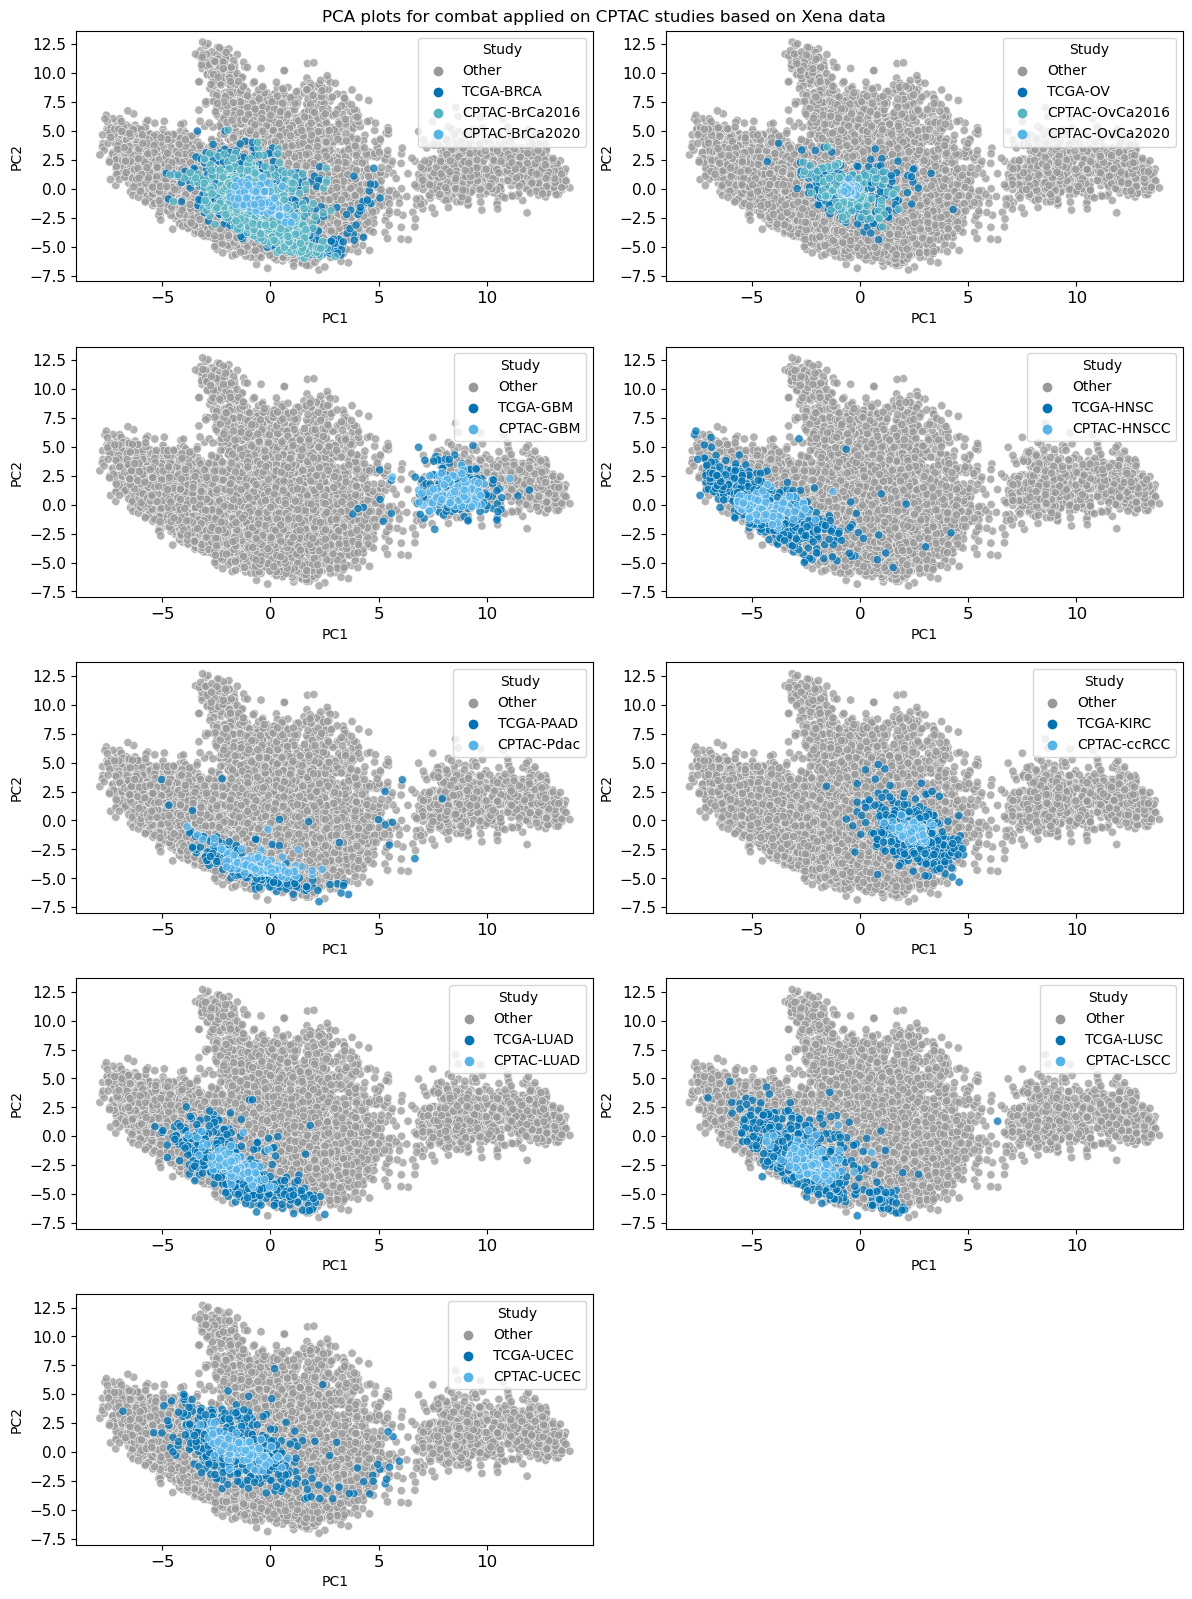

In [29]:
with plt.rc_context({'axes.linewidth': 0.8, 'xtick.labelsize':12, 'ytick.labelsize':11, }):
    figure, ax = plt.subplots(5, 2, figsize=(12, 16))
    plot_pca_studywise(pcs_batch, ax[0, 0], ['TCGA-BRCA', 'CPTAC-BrCa2016', 'CPTAC-BrCa2020'], {"CPTAC-BrCa2020":"#56B4E9",
                                                                                                  "CPTAC-BrCa2016": "#56b4c2", 
                                                                                                  "TCGA-BRCA":"#0072B2", 
                                                                                                  "Other": "#999999"})
    plot_pca_studywise(pcs_batch, ax[0, 1], ['TCGA-OV', 'CPTAC-OvCa2016', 'CPTAC-OvCa2020'], {"CPTAC-OvCa2020":"#56B4E9",
                                                                                             "CPTAC-OvCa2016": "#56b4c2", 
                                                                                             "TCGA-OV":"#0072B2", 
                                                                                             "Other": "#999999"})
    plot_pca_studywise(pcs_batch, ax[1, 0], ['TCGA-GBM', 'CPTAC-GBM'], {"CPTAC-GBM":"#56B4E9", "TCGA-GBM":"#0072B2", 
                                                                         "Other": "#999999"})
    plot_pca_studywise(pcs_batch, ax[1, 1], ['TCGA-HNSC', 'CPTAC-HNSCC'], {"CPTAC-HNSCC":"#56B4E9", "TCGA-HNSC":"#0072B2", 
                                                                         "Other": "#999999"})
    plot_pca_studywise(pcs_batch, ax[2, 0], ['TCGA-PAAD', 'CPTAC-Pdac'], {"CPTAC-Pdac":"#56B4E9", "TCGA-PAAD":"#0072B2", 
                                                                         "Other": "#999999"})
    plot_pca_studywise(pcs_batch, ax[2, 1], ['TCGA-KIRC', 'CPTAC-ccRCC'], {"CPTAC-ccRCC":"#56B4E9",
                                                                           "TCGA-KIRC":"#0072B2", 
                                                                           "Other": "#999999"})
    plot_pca_studywise(pcs_batch, ax[3, 0], ['TCGA-LUAD', 'CPTAC-LUAD'], {"CPTAC-LUAD":"#56B4E9", "TCGA-LUAD":"#0072B2", 
                                                                         "Other": "#999999"})
    plot_pca_studywise(pcs_batch, ax[3, 1], ['TCGA-LUSC', 'CPTAC-LSCC'], {"CPTAC-LSCC":"#56B4E9", "TCGA-LUSC":"#0072B2", 
                                                                         "Other": "#999999"})
    plot_pca_studywise(pcs_batch, ax[4, 0], ['TCGA-UCEC', 'CPTAC-UCEC'], {"CPTAC-UCEC":"#56B4E9", "TCGA-UCEC":"#0072B2", 
                                                                         "Other": "#999999"})
    ax[4, 1].axis('off')
    plt.subplots_adjust(wspace=0.45, hspace=0.45)
    figure.tight_layout(pad=1.5)
    figure.suptitle('PCA plots for combat applied on CPTAC studies based on Xena data', y = 1)